In [1]:
import json
from pathlib import Path
import yaml

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

from pan25_genai_detection.evaluator import evaluator

In [2]:
OUT_DIR = Path('../data/pan-task-eval-out/')
OUT_DIR.mkdir(parents=True, exist_ok=True)

sns.set_context('paper', font_scale=1.2)
sns.set_style('whitegrid')

plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.linewidth'] = .75
plt.rcParams['patch.linewidth'] = .5
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['lines.dashed_pattern'] = (10, 5)
plt.rcParams['lines.linewidth'] = .75
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Libertinus Sans', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.family'] = 'sans-serif'

# Webis colours
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    '#90d7de',
    '#9ed977',
    '#ffab9e',
    '#d6acfa',
    '#ffc640',
    '#68b4c2',
    '#62ba61',
    '#ff6f52',
    '#bb86f3',
    '#e8a01d',
])

### Load Data

In [3]:
team_map = {
    'mdok': 'Macko',
    'diveye': 'Basani',
    'moadmoad': 'Liu',
    'yangjlg': 'Yang',
    'steely': 'Seeliger',
    'nexus-interrogators': 'Zaidi',
    'unibuc-nlp': 'Marchitan',
    'baseline-tf-idf': 'Baseline TF-IDF SVM',
    'cnlp-nits-pp': 'Sai Teja',
    'advacheck': 'Voznyuk',
    'iimasnlp': 'Valdez-Valenzuela',
    'sinai-inta': 'Jimeno-Gonzalez',
    'styloch': 'Ochab',
    'pindrop': 'Sun',
    'ds-gt-pan': 'Ostrower',
    'shushantatud': 'Pudasaini',
    'iunlp': 'Larson',
    's-titze': 'Titze',
    'baseline-binoculars-llama-3.1': 'Baseline Binoculars Llama3.1',
    'asdkklkk': 'Liang',
    'hiwiy': 'Huang',
    'baseline-ppmd': 'Baseline PPMd CBC',
    'team-a': 'Kumar',
    'felix-volpel': 'Völpel',
}

source_map = {
    'brennan-greenstadt': 'Brennan Greenstadt',
    'brennan-greenstadt-obfuscated': 'Brennan-Greenstadt (Obfuscated)',
    'riddell-juola': 'Riddell-Juola',
    'riddell-juola-o1-deepseek': 'Riddell-Juola (o1)',
    'riddell-juola-obfuscated': 'Riddell-Juola (Obfuscated)',
    'gutenberg-19c-fiction': 'Gutenberg Fiction',
    'gutenberg-19c-fiction-o1': 'Gutenberg Fiction (o1)',
    'gutenberg-19c-fiction-obfuscated': 'Gutenberg Fiction (Obfuscated)',
    'pan24-o1': 'PAN\'24 (o1)',
    'pan24-test': 'PAN\'24 Test',
    'eloquent': 'ELOQUENT',
}

In [4]:
def load_run_jsonl(infile):
    for l in open(infile):
        j = json.loads(l)
        obj = {k: v for k, v in j.items() if k in ['dataset', 'team', 'software', 'run_id']}
        obj['eval_field'] = 'all'
        obj['eval_value'] = 'all'
        eval_keys = [k for k in j['evaluation'] if k.startswith('_eval-')]
        if obj['team'] == 'baseline':
            if obj['software'] == 'baseline-binoculars-tiny-llama':
                # Skip inofficial baseline
                continue
            obj['team'] =  obj['software']
        obj['team'] = team_map.get(obj['team'], obj['team'])
        obj_all = obj.copy()
        obj_all.update({'resource_' + k: v for k, v in j['used_resources'].items()})
        obj_all.update({k: v for k, v in j['evaluation'].items() if k not in eval_keys})
        yield obj_all

        for k in eval_keys:
            obj['eval_field'] = k.replace('_eval-', '')
            for kv, v in j['evaluation'][k].items():
                obj['eval_value'] = kv if obj['eval_field'] != 'source' else source_map.get(kv, kv)
                obj.update(**v)
                yield obj.copy()

# Load run evaluations, but keep only last runif softwares were executed multiple times
df_run_eval_raw = (pd.DataFrame(load_run_jsonl('../data/tira/runs-gen-ai-authorship-verification/runs.jsonl'))
                   .sort_values('run_id')
                   .drop_duplicates(subset=['dataset', 'team', 'software', 'eval_field', 'eval_value'], keep='last')
                   .set_index(['dataset', 'team', 'software', 'run_id', 'eval_field', 'eval_value']))
_resource_cols = [c for c in df_run_eval_raw.columns if c.startswith('resource_')]
df_resources = df_run_eval_raw[_resource_cols].dropna()
df_resources = df_resources.reset_index()
df_resources['team'] = df_resources['team'].map(lambda x: team_map.get(f'baseline-{x}' if 'baseline' in x else x, x))
df_resources['resource_wallcock'] = df_resources['resource_wallcock'].map(lambda x: float(x.replace(' ms', '')) / 1000 / 60)   # [sick!]
df_resources.set_index(df_run_eval_raw.index.names, inplace=True)

df_run_eval_raw = df_run_eval_raw.drop(columns=_resource_cols)

# Keep only highest by mean score on main test set
softwares = set(i[1] for i in df_run_eval_raw.loc['pan25-generative-ai-detection-20250604-test']
                .query('eval_field == "all"')
                .groupby('team')
                .idxmax()['mean'])
df_run_eval_raw = df_run_eval_raw.query('software in @softwares')
# df_resources = df_resources.query('software in @softwares')

# Drop "all"
df_run_eval_raw = df_run_eval_raw.query('eval_field != "all"')

In [5]:
# Load case ID map
id_map = {}
for f in Path('../data/sampled').glob('*-orig-ids.jsonl'):
    for l in open(f, 'r'):
        j = json.loads(l)
        assert j['id'] not in id_map
        id_map[j['id']] = j['orig_id']

In [6]:
# Load raw predictions and back-translate case IDs
df_pred_raw = []
for pt in tqdm(list(Path('../data/tira/runs-gen-ai-authorship-verification').glob('*/run.prototext')), desc='Loading raw predictions'):
    y = yaml.full_load(open(pt))
    try:
        t, s = df_run_eval_raw.xs((y['inputDataset'], y['runId']), level=['dataset', 'run_id']).index.unique().values[0][:2]
    except KeyError:
        # Software filtered
        continue
    df_pred_raw.append(pd.read_json(next(pt.parent.glob('output/*.jsonl')), lines=True)[['id', 'label']])
    df_pred_raw[-1]['dataset'] = y['inputDataset']
    df_pred_raw[-1]['run_id'] = y['runId']
    df_pred_raw[-1]['team'] = t if t != 'baseline' else s
    df_pred_raw[-1]['software'] = s
    df_pred_raw[-1]['id'] = df_pred_raw[-1]['id'].map(lambda x: id_map[x])

df_pred_raw = pd.concat(df_pred_raw).sort_values('id').set_index(['dataset', 'team', 'software', 'run_id', 'id'])

Loading raw predictions:   0%|          | 0/150 [00:00<?, ?it/s]

In [7]:
# Merge ELOQUENT submissions
rows = []
for (t, s), d in df_pred_raw.query('dataset.str.contains("-eloquent-")').groupby(['team', 'software']):
    r = {
            'dataset': 'pan25-generative-ai-detection-eloquent-test-all',
            'team': t,
            'software': s,
            'run_id': tuple(d.index.get_level_values('run_id').unique()),
            'eval_field': 'model',
        }

    for i, d_ in enumerate([d.query('id.str.startswith("eloquent25/human/")'),
                            d.query('not id.str.startswith("eloquent25/human/")'),
                            d]):
        if i in [0, 1]:
            r_ = {
                **r,
                'eval_field': 'model',
                'eval_value': 'eloquent-human' if i == 0 else 'eloquent-llm',
                **{k: (np.float64(v) if type(v) is not list else v)
                   for k, v in evaluator.evaluate_all(np.array([i] * len(d_)), np.squeeze(d_['label'].values)).items()},
            }
        else:
            r_ = {
                **r,
                'eval_field': 'source',
                'eval_value': 'ELOQUENT',
                **evaluator.evaluate_all(
                    d_.reset_index()['id'].map(lambda x: not x.startswith('eloquent25/human/')).values,
                    np.squeeze(d_['label'].values)),
            }

        rows.append(pd.Series(list(r_.values()), index=list(r_.keys())))

df_run_eval = pd.concat([
    df_run_eval_raw.query('not dataset.str.contains("-eloquent-")'),
    pd.DataFrame(rows).set_index(df_run_eval_raw.index.names)
])

# Fix F1 and F0.5u NaN values
def _fix_f1_nan(s):
    if np.isnan(s['f1']) and s['c@1'] == 1.0:
        s['f1'] = 1.0
        s['f05u'] = 1.0
    return s

df_run_eval = df_run_eval.apply(_fix_f1_nan, axis=1)

def _recalc_means(s):
    s['mean'] = float(np.mean([v for k, v in s.dropna().items() if type(v) is float and k != 'mean']))
    return s

# Update means
df_run_eval = df_run_eval.apply(_recalc_means, axis=1)

# Calculate FPR, FNR
df_run_eval['fpr'] = df_run_eval['confusion'].map(lambda s: s[0][1] / np.sum(s[0]) if np.sum(s[0]) else np.nan)
df_run_eval['fnr'] = df_run_eval['confusion'].map(lambda s: s[1][0] / np.sum(s[1]) if np.sum(s[1]) else np.nan)
df_run_eval['human_prec'] = df_run_eval['confusion'].map(lambda s: s[0][0] / (s[0][0] + s[1][0]) if (s[0][0] + s[1][0]) else np.nan)
df_run_eval['human_rec'] = df_run_eval['confusion'].map(lambda s: s[0][0] / np.sum(s[0]) if np.sum(s[0]) else np.nan)

### PAN Evaluation

In [8]:
print('Datasets:\n - ', end='')
print('\n - '.join(df_run_eval.query('eval_field == "source"').reset_index()['eval_value'].unique()))

Datasets:
 - Brennan Greenstadt
 - Riddell-Juola (Obfuscated)
 - Riddell-Juola (o1)
 - Riddell-Juola
 - PAN'24 Test
 - PAN'24 (o1)
 - Gutenberg Fiction (Obfuscated)
 - Gutenberg Fiction (o1)
 - Gutenberg Fiction
 - Brennan-Greenstadt (Obfuscated)
 - ELOQUENT


In [9]:
pan_leaderboard_source = df_run_eval.query('eval_field == "source"').groupby(['team', 'software']).mean(numeric_only=True).sort_values(['mean'], ascending=False)
pan_leaderboard_export = pan_leaderboard_source.reset_index()[['team', 'software', 'roc-auc', 'brier', 'c@1', 'f1', 'f05u', 'mean', 'fpr', 'fnr']].reset_index()
pan_leaderboard_export.to_html(OUT_DIR / 'leaderboard.html', float_format=lambda f: f'{f:.3f}')
pan_leaderboard_export.to_latex(OUT_DIR / 'leaderboard.tex', float_format=lambda f: f'{f:.3f}')
pan_leaderboard_source.round(3)

,,roc-auc,brier,c@1,f1,f05u,mean,fpr,fnr,human_prec,human_rec
team,software,,,,,,,,,,
Macko,mdok,0.995,0.984,0.982,0.989,0.993,0.989,0.006,0.018,0.894,0.994
Valdez-Valenzuela,isg-graph-v3,0.939,0.902,0.897,0.926,0.960,0.929,0.020,0.107,0.511,0.980
Liu,modernbert,0.962,0.891,0.889,0.923,0.963,0.928,0.005,0.120,0.499,0.995
Seeliger,fine-roberta,0.912,0.898,0.896,0.930,0.959,0.925,0.082,0.103,0.565,0.918
Voznyuk,watery-bag,0.899,0.898,0.898,0.929,0.962,0.924,0.035,0.107,0.566,0.965
Yang,pink-condenser,0.930,0.893,0.886,0.920,0.960,0.923,0.018,0.122,0.560,0.982
Zaidi,sensitive-liason,0.931,0.891,0.887,0.924,0.958,0.922,0.062,0.115,0.500,0.938
hello-world,tart-objective,0.963,0.900,0.897,0.904,0.946,0.922,0.106,0.093,0.462,0.894
Baseline TF-IDF SVM,baseline-tf-idf,0.963,0.900,0.897,0.904,0.946,0.922,0.106,0.093,0.462,0.894


In [10]:
df_resources

resource_wallcock  \
dataset                                            team              software         run_id              eval_field eval_value                      
pan25-generative-ai-detection-20250604-test        Macko             mdok             2025-06-04-16-11-23 all        all                 14.306917   
                                                   Liu               modernbert       2025-06-04-16-11-42 all        all                  4.071717   
                                                                     Qwen3            2025-06-04-16-12-07 all        all                 20.673367   
                                                                     modernbert+qwen3 2025-06-04-16-12-34 all        all                 22.990633   
                                                   Sai Teja          loyal-coot       2025-06-04-16-13-21 all        all                  0.950150   
...                                                                                                                                            ...   
pan25-generative-ai-detection-eloquent-20250610... Ochab             medium-single    2025-06-11-00-42-43 all        all                  0.137783   
                                                                     big-cv           2025-06-11-00-43-53 all        all                  0.185983   
                                                                     big-single       2025-06-11-00-45-03 all        all                  0.141483   
                                                                     big-cv-culled    2025-06-11-00-46-01 all        all                  0.177750   
                                                   Valdez-Valenzuela isg-graph-v3     2025-06-11-12-48-56 all        all                  2.487100   

                                                                                                                                 resource_CPU (Max)  \
dataset                                            team              software         run_id              eval_field eval_value                       
pan25-generative-ai-detection-20250604-test        Macko             mdok             2025-06-04-16-11-23 all        all                       10.0   
                                                   Liu               modernbert       2025-06-04-16-11-42 all        all                       10.0   
                                                                     Qwen3            2025-06-04-16-12-07 all        all                       20.0   
                                                                     modernbert+qwen3 2025-06-04-16-12-34 all        all                       19.0   
                                                   Sai Teja          loyal-coot       2025-06-04-16-13-21 all        all                       10.0   
...                                                                                                                                             ...   
pan25-generative-ai-detection-eloquent-20250610... Ochab             medium-single    2025-06-11-00-42-43 all        all                       10.0   
                                                                     big-cv           2025-06-11-00-43-53 all        all                       10.0   
                                                                     big-single       2025-06-11-00-45-03 all        all                       10.0   
                                                                     big-cv-culled    2025-06-11-00-46-01 all        all                       10.0   
                                                   Valdez-Valenzuela isg-graph-v3     2025-06-11-12-48-56 all        all                       10.0   

                                                                                                                                 resource_RAM (Max)  \
dataset                                            team        

In [11]:
fields = ['mean', 'fpr', 'fnr']
(df_run_eval.query('eval_field == "source"')
 .reset_index()[['team', 'eval_value', *fields]]
 .set_index(['team', 'eval_value'])
 .unstack()
 .describe()
 .transpose()
 .dropna()
 .round(3))

count   mean    std    min    25%  \
     eval_value                                                           
mean Brennan Greenstadt                27.0  0.964  0.060  0.785  0.971   
     Brennan-Greenstadt (Obfuscated)   27.0  0.711  0.110  0.369  0.668   
     ELOQUENT                          27.0  0.764  0.111  0.390  0.706   
     Gutenberg Fiction                 27.0  0.942  0.111  0.580  0.975   
     Gutenberg Fiction (Obfuscated)    27.0  0.953  0.081  0.736  0.968   
     Gutenberg Fiction (o1)            27.0  0.974  0.041  0.842  0.966   
     PAN'24 (o1)                       27.0  0.939  0.085  0.659  0.913   
     PAN'24 Test                       27.0  0.902  0.119  0.631  0.917   
     Riddell-Juola                     27.0  0.954  0.063  0.779  0.945   
     Riddell-Juola (Obfuscated)        27.0  0.746  0.097  0.569  0.688   
     Riddell-Juola (o1)                27.0  0.992  0.012  0.959  0.991   
fpr  Brennan Greenstadt                27.0  0.151  0.279  0.000  0.014   
     Brennan-Greenstadt (Obfuscated)   27.0  0.156  0.251  0.000  0.033   
     ELOQUENT                          27.0  0.148  0.275  0.000  0.000   
     Gutenberg Fiction                 27.0  0.098  0.258  0.000  0.002   
     PAN'24 Test                       27.0  0.216  0.292  0.007  0.055   
     Riddell-Juola                     27.0  0.199  0.281  0.000  0.035   
     Riddell-Juola (Obfuscated)        27.0  0.167  0.251  0.000  0.000   
fnr  Brennan Greenstadt                27.0  0.015  0.037  0.000  0.000   
     Brennan-Greenstadt (Obfuscated)   27.0  0.420  0.170  0.000  0.332   
     ELOQUENT                          27.0  0.344  0.166  0.000  0.284   
     Gutenberg Fiction                 27.0  0.040  0.060  0.000  0.009   
     Gutenberg Fiction (Obfuscated)    27.0  0.064  0.113  0.000  0.010   
     Gutenberg Fiction (o1)            27.0  0.029  0.052  0.000  0.000   
     PAN'24 (o1)                       27.0  0.080  0.124  0.000  0.010   
     PAN'24 Test                       27.0  0.018  0.032  0.000  0.002   
     Riddell-Juola                     27.0  0.018  0.047  0.000  0.000   
     Riddell-Juola (Obfuscated)        27.0  0.375  0.169  0.000  0.276   
     Riddell-Juola (o1)                27.0  0.006  0.014  0.000  0.000   

                                        50%    75%    max  
     eval_value                                            
mean Brennan Greenstadt               0.989  0.998  1.000  
     Brennan-Greenstadt (Obfuscated)  0.704  0.778  0.909  
     ELOQUENT                         0.781  0.816  0.993  
     Gutenberg Fiction                0.985  0.993  0.998  
     Gutenberg Fiction (Obfuscated)   0.986  0.993  1.000  
     Gutenberg Fiction (o1)           0.993  1.000  1.000  
     PAN'24 (o1)                      0.967  0.993  1.000  
     PAN'24 Test                      0.949  0.974  0.995  
     Riddell-Juola                    0.981  0.995  1.000  
     Riddell-Juola (Obfuscated)       0.725  0.800  0.999  
     Riddell-Juola (o1)               0.999  1.000  1.000  
fpr  Brennan Greenstadt               0.057  0.107  1.000  
     Brennan-Greenstadt (Obfuscated)  0.044  0.156  1.000  
     ELOQUENT                         0.045  0.159  1.000  
     Gutenberg Fiction                0.005  0.020  1.000  
     PAN'24 Test                      0.088  0.182  1.000  
     Riddell-Juola                    0.125  0.188  1.000  
     Riddell-Juola (Obfuscated)       0.074  0.167  1.000  
fnr  Brennan Greenstadt               0.002  0.010  0.182  
     Brennan-Greenstadt (Obfuscated)  0.443  0.510  0.847  
     ELOQUENT                         0.351  0.437  0.796  
     Gutenberg Fiction                0.017  0.041  0.251  
     Gutenberg Fiction (Obfuscated)   0.010  0.040  0.390  
     Gutenberg Fiction (o1)           0.005  0.032  0.225  
     PAN'24 (o1)                      0.030  0.105  0.470  
     PAN'24 Test                      0.007  0.015  0.125  
     Riddell-Juola              

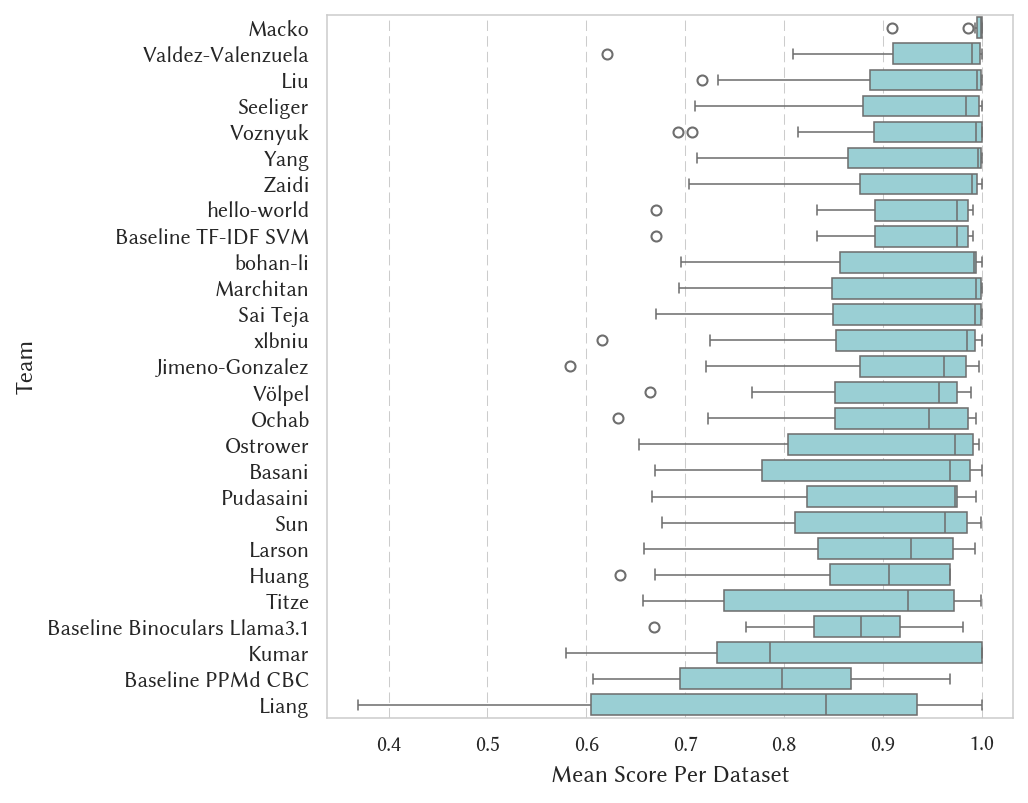

In [40]:
plt.figure(figsize=(7, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "source"'), x='mean', y='team', linewidth=.75, order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('Mean Score Per Dataset')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_source.pdf')
plt.show()

In [13]:
df_run_eval.query('eval_field == "source" and team == "Macko"')

roc-auc  \
dataset                                         team  software run_id                                     eval_field eval_value                                 
pan25-generative-ai-detection-20250604-test     Macko mdok     2025-06-04-16-11-23                        source     Brennan Greenstadt                 1.000   
                                                                                                                     Riddell-Juola (Obfuscated)         1.000   
                                                                                                                     Riddell-Juola (o1)                   NaN   
                                                                                                                     Riddell-Juola                      0.996   
                                                                                                                     PAN'24 Test                        0.993   
                                                                                                                     PAN'24 (o1)                          NaN   
                                                                                                                     Gutenberg Fiction (Obfuscated)       NaN   
                                                                                                                     Gutenberg Fiction (o1)               NaN   
                                                                                                                     Gutenberg Fiction                  0.998   
                                                                                                                     Brennan-Greenstadt (Obfuscated)    0.981   
pan25-generative-ai-detection-eloquent-test-all Macko mdok     (2025-06-11-00-34-20, 2025-06-05-12-33-10) source     ELOQUENT                           0.999   

                                                                                                                                                      brier  \
dataset                                         team  software run_id                                     eval_field eval_value                               
pan25-generative-ai-detection-20250604-test     Macko mdok     2025-06-04-16-11-23                        source     Brennan Greenstadt               0.999   
                                                                                                                     Riddell-Juola (Obfuscated)       0.998   
                                                                                                                     Riddell-Juola (o1)               1.000   
                                                                                                                     Riddell-Juola                    0.998   
                                                                                                                     PAN'24 Test                      0.987   
                                                                                                                     PAN'24 (o1)                      1.000   
                                                                                                                     Gutenberg Fiction (Obfuscated)   1.000   
                                                                                                                     Gutenberg Fiction (o1)           1.000   
                                                                                                                     Gutenberg Fiction                0.997   
                                                                                                                     Brennan-Greenstadt (Obfuscated)  0.861   
pan25-generative-ai-detection-eloquent-test-all Macko mdok     (2025-06-11-00-34-20, 2025-06-05-12-33-10) source     ELOQUENT                       

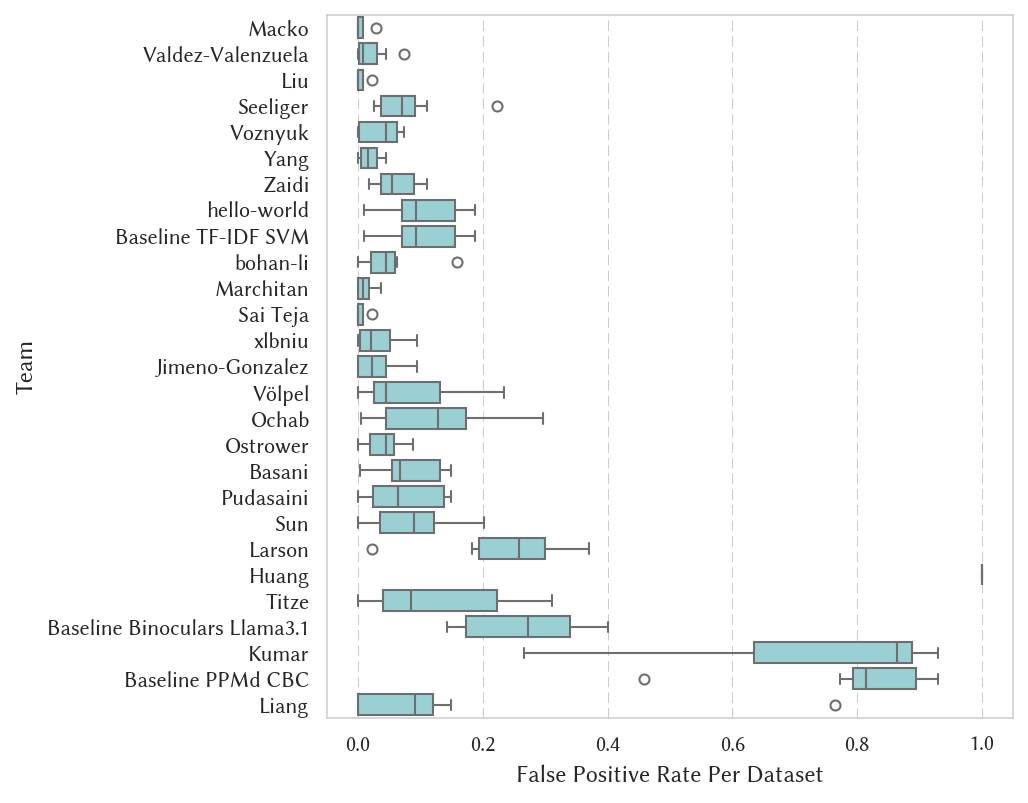

In [14]:
plt.figure(figsize=(7, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "source"'), x='fpr', y='team', order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('False Positive Rate Per Dataset')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_source_fpr.pdf')
plt.show()

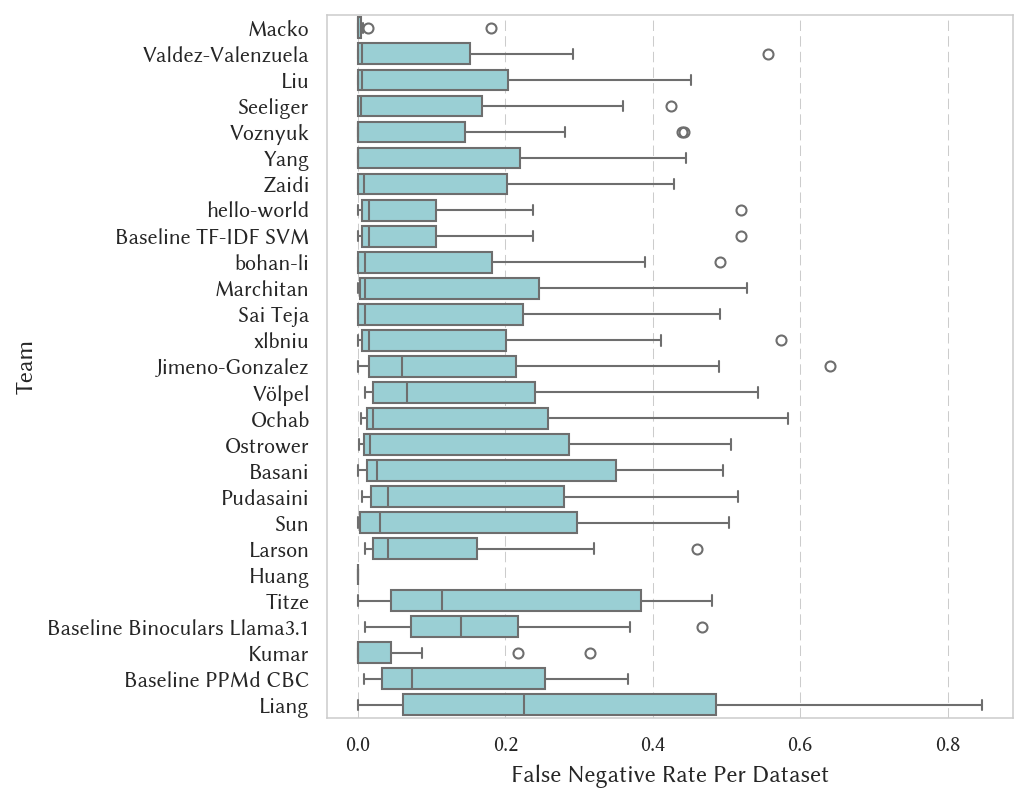

In [15]:
plt.figure(figsize=(7, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "source"'), x='fnr', y='team', order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('False Negative Rate Per Dataset')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_source_fpr.pdf')
plt.show()

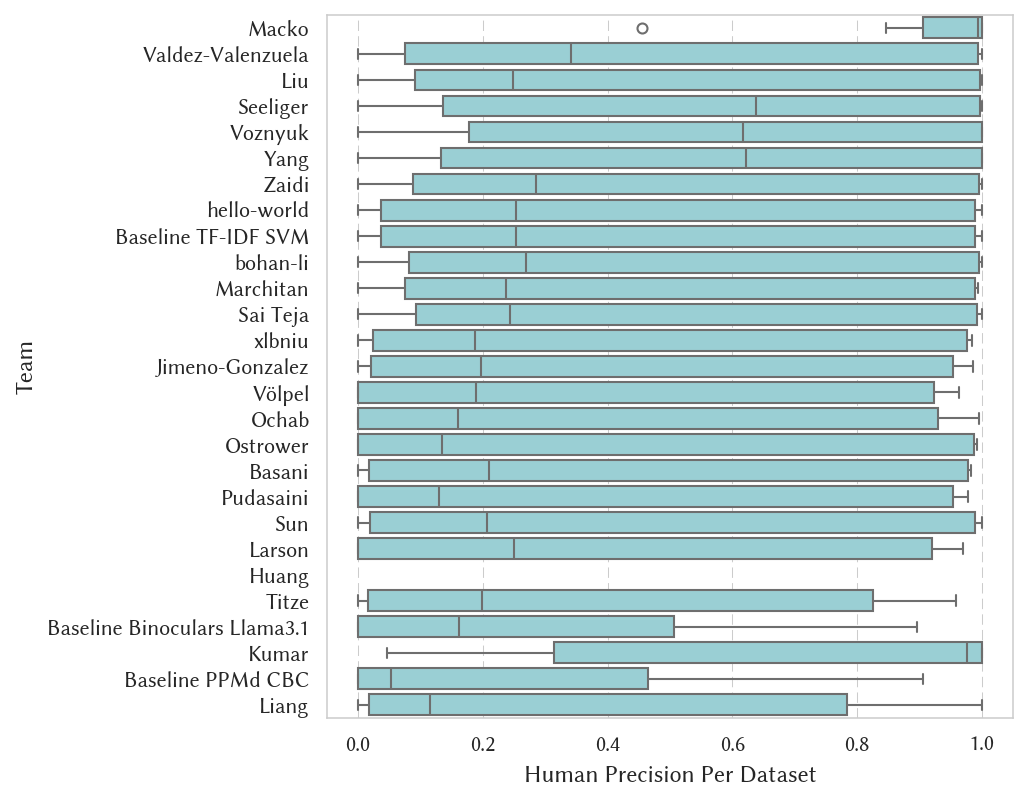

In [16]:
plt.figure(figsize=(7, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "source"'), x='human_prec', y='team', order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('Human Precision Per Dataset')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_source_prec.pdf')
plt.show()

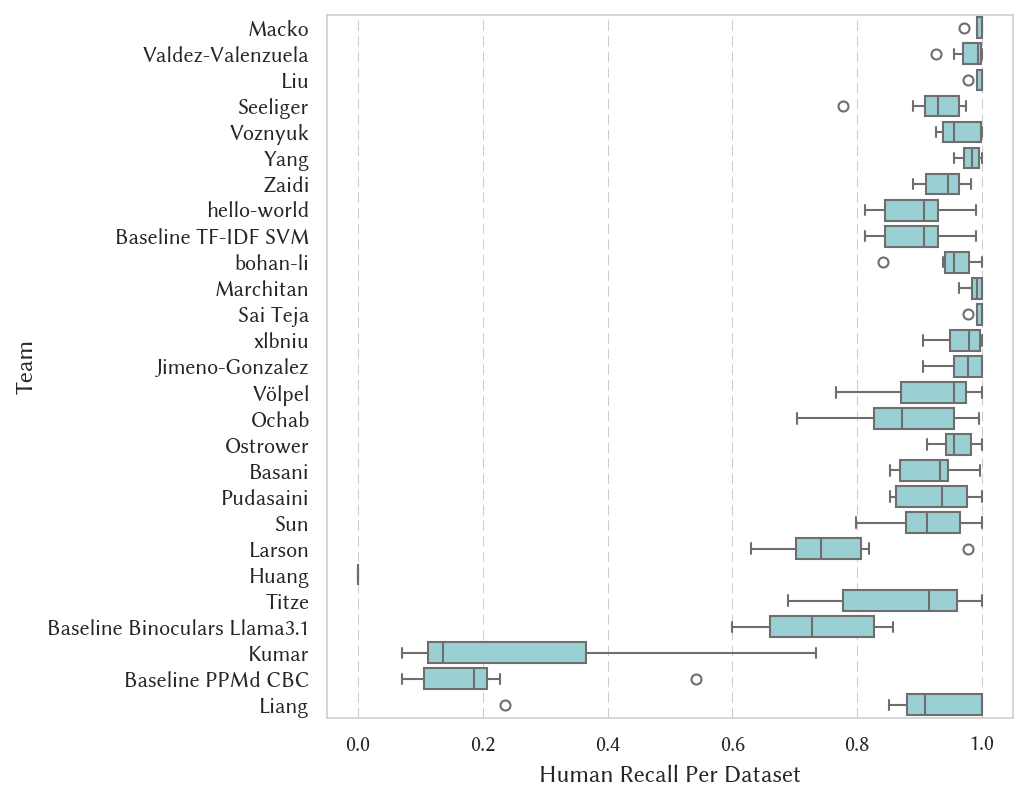

In [17]:
plt.figure(figsize=(7, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "source"'), x='human_rec', y='team', order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('Human Recall Per Dataset')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_source_rec.pdf')
plt.show()

In [18]:
pan_leaderboard_model = df_run_eval.query('eval_field == "model"').groupby(['team', 'software']).mean(numeric_only=True).sort_values(['mean'], ascending=False)
pan_leaderboard_model.round(3)

,,roc-auc,brier,c@1,f1,f05u,mean,fpr,fnr,human_prec,human_rec
team,software,,,,,,,,,,
Macko,mdok,NaN,0.970,0.966,0.953,0.964,0.963,0.003,0.035,0.250,0.997
Huang,connected-svn,NaN,0.855,0.949,0.949,0.949,0.925,1.000,0.000,NaN,0.000
Kumar,deafening-template,NaN,0.868,0.868,0.883,0.908,0.882,0.852,0.093,0.125,0.148
Larson,persistent-strut,NaN,0.873,0.873,0.871,0.909,0.881,0.151,0.126,0.062,0.849
Seeliger,fine-roberta,NaN,0.859,0.857,0.842,0.883,0.860,0.045,0.149,0.111,0.955
Baseline Binoculars Llama3.1,baseline-binoculars-llama-3.1,NaN,0.865,0.827,0.833,0.884,0.852,0.237,0.165,0.065,0.763
Baseline PPMd CBC,baseline-ppmd,NaN,0.828,0.831,0.836,0.881,0.844,0.700,0.126,0.077,0.300
hello-world,tart-objective,NaN,0.877,0.841,0.821,0.840,0.843,0.118,0.142,0.100,0.882
Baseline TF-IDF SVM,baseline-tf-idf,NaN,0.877,0.841,0.821,0.840,0.843,0.118,0.142,0.100,0.882


In [19]:
pan_leaderboard_genre = df_run_eval.query('eval_field == "genre"').groupby(['team', 'software']).mean(
    numeric_only=True).sort_values(['mean'], ascending=False)
pan_leaderboard_genre.round(3)

,,roc-auc,brier,c@1,f1,f05u,mean,fpr,fnr,human_prec,human_rec
team,software,,,,,,,,,,
Macko,mdok,0.996,0.987,0.985,0.991,0.994,0.991,0.009,0.013,0.890,0.991
Seeliger,fine-roberta,0.950,0.924,0.922,0.947,0.964,0.943,0.081,0.072,0.784,0.919
Liu,modernbert,0.974,0.914,0.913,0.940,0.970,0.943,0.006,0.094,0.627,0.994
Yang,pink-condenser,0.966,0.920,0.913,0.940,0.968,0.943,0.020,0.091,0.628,0.980
Zaidi,sensitive-liason,0.969,0.918,0.914,0.941,0.965,0.942,0.051,0.085,0.624,0.949
Sai Teja,tomato-conduction,0.939,0.913,0.913,0.940,0.970,0.937,0.006,0.094,0.626,0.994
hello-world,tart-objective,0.976,0.914,0.914,0.923,0.954,0.937,0.086,0.076,0.626,0.914
Baseline TF-IDF SVM,baseline-tf-idf,0.976,0.914,0.914,0.923,0.954,0.937,0.086,0.076,0.626,0.914
Marchitan,tangy-arch,0.968,0.916,0.899,0.927,0.962,0.935,0.011,0.109,0.619,0.989


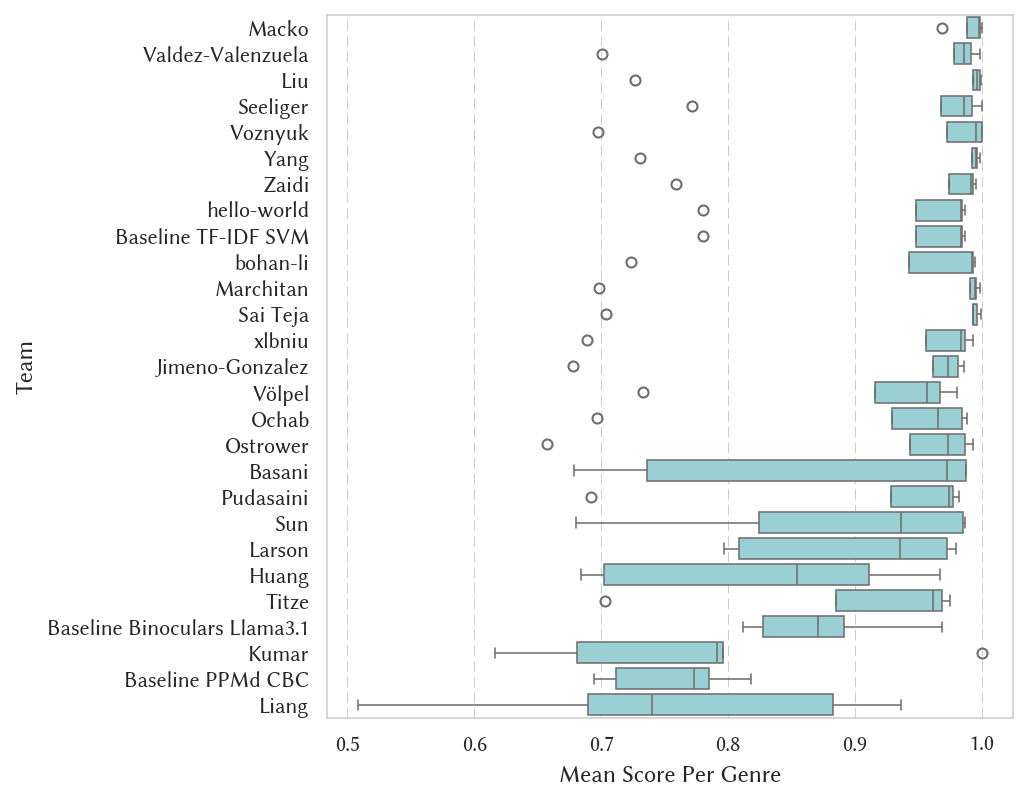

In [20]:
plt.figure(figsize=(7, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "genre"'), x='mean', y='team', linewidth=.75, order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('Mean Score Per Genre')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_genre.pdf')
plt.show()

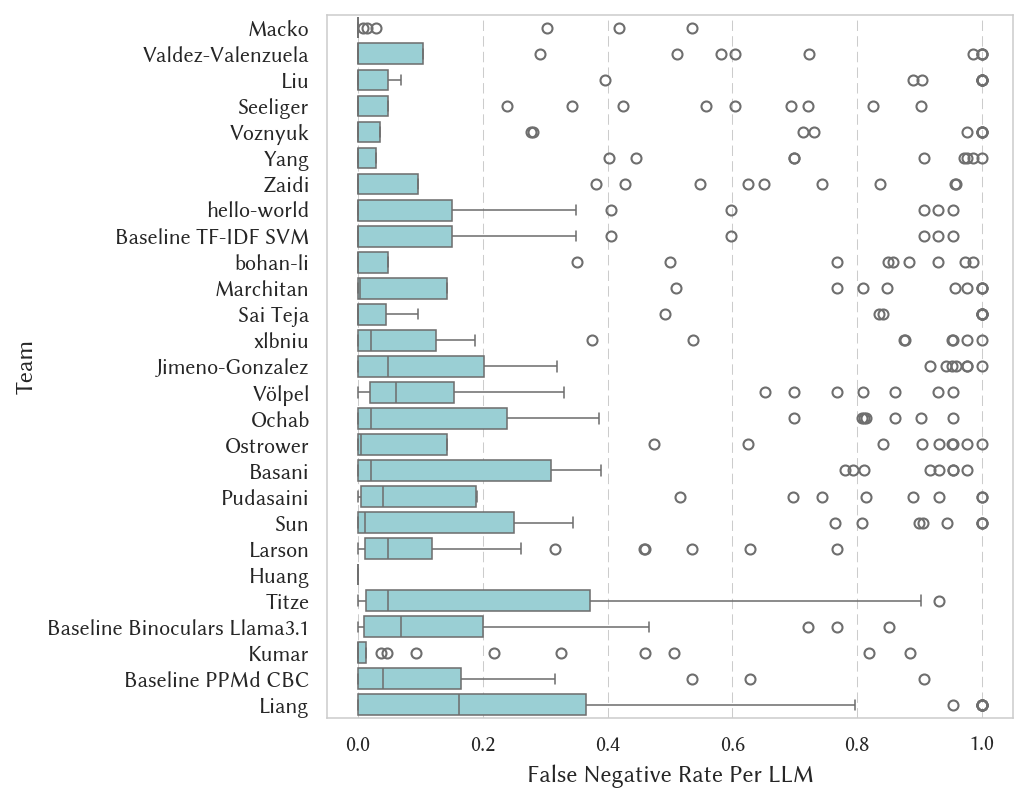

In [21]:
plt.figure(figsize=(7, 5.5))
sns.boxplot(df_run_eval.query('eval_field == "model" and eval_value != "human"'), x='fnr', y='team', linewidth=.75, order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('False Negative Rate Per LLM')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_fnr.pdf')
plt.show()

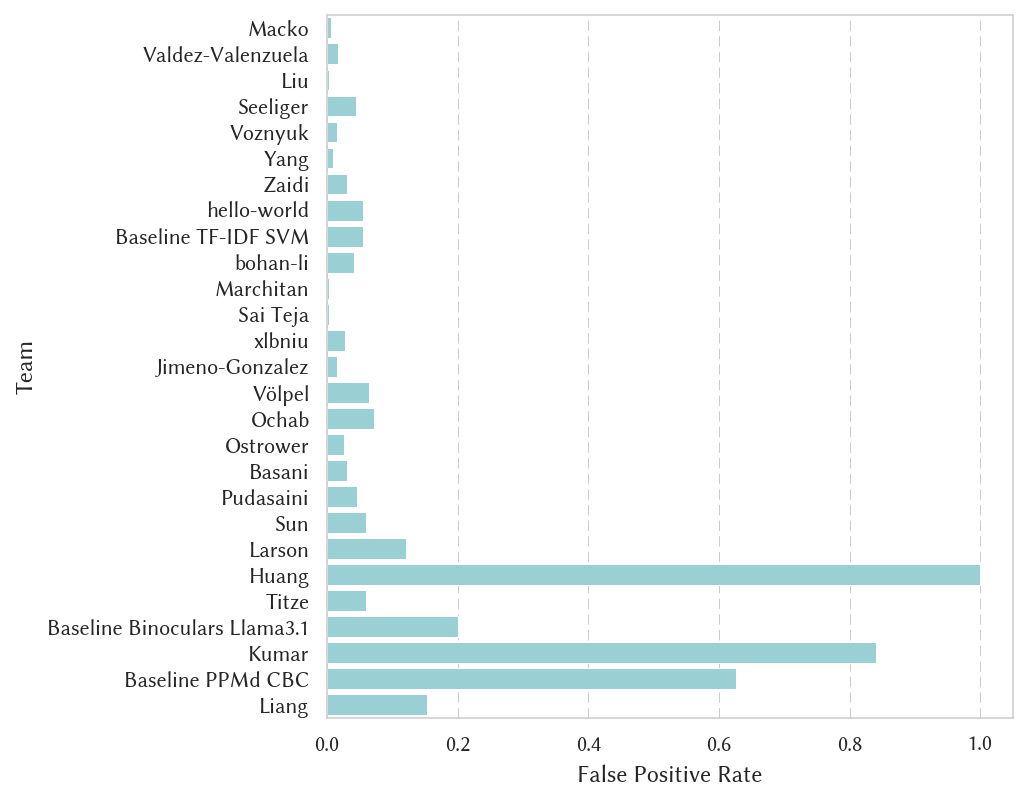

In [22]:
plt.figure(figsize=(7, 5.5))
sns.barplot(df_run_eval.query('eval_field == "model" and eval_value == "human"'), x='fpr', y='team', order=pan_leaderboard_source.index.get_level_values('team'))
plt.xlabel('False Positive Rate')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig(OUT_DIR / 'pan_leaderboard_fpr.pdf')
plt.show()

In [23]:
pan_dataset_difficulty_all = df_run_eval.query('eval_field == "source"')[['brier', 'c@1', 'mean', 'fpr', 'fnr']]
pan_dataset_difficulty_all['brier'] = 1.0 - pan_dataset_difficulty_all['brier']
pan_dataset_difficulty_all['c@1'] = 1.0 - pan_dataset_difficulty_all['c@1']
pan_dataset_difficulty_all['mean'] = 1.0 - pan_dataset_difficulty_all['mean']
pan_dataset_difficulty = pan_dataset_difficulty_all.groupby(['eval_value']).median(numeric_only=True).sort_values(['c@1'], ascending=False)
pan_dataset_difficulty.round(3)

,brier,c@1,mean,fpr,fnr
eval_value,,,,,
Riddell-Juola (Obfuscated),0.379,0.426,0.275,0.074,0.442
Brennan-Greenstadt (Obfuscated),0.353,0.397,0.296,0.044,0.443
ELOQUENT,0.264,0.349,0.219,0.045,0.351
PAN'24 Test,0.061,0.048,0.051,0.088,0.007
PAN'24 (o1),0.046,0.031,0.033,NaN,0.030
Riddell-Juola,0.024,0.024,0.019,0.125,0.002
Gutenberg Fiction,0.017,0.014,0.015,0.005,0.017
Brennan Greenstadt,0.013,0.011,0.011,0.057,0.002
Gutenberg Fiction (Obfuscated),0.030,0.010,0.014,NaN,0.010


In [24]:
teams_top10 = pan_leaderboard_source.index.get_level_values('team')[:10]
pan_dataset_difficulty_top10_all = pan_dataset_difficulty_all.query('team in @teams_top10')
pan_dataset_difficulty_top10 = pan_dataset_difficulty_top10_all.groupby(['eval_value']).median(numeric_only=True).sort_values(['c@1'], ascending=False)
pan_dataset_difficulty_top10.round(3)

,brier,c@1,mean,fpr,fnr
eval_value,,,,,
Riddell-Juola (Obfuscated),0.386,0.413,0.260,0.056,0.428
Brennan-Greenstadt (Obfuscated),0.307,0.362,0.252,0.056,0.410
ELOQUENT,0.291,0.300,0.204,0.023,0.321
PAN'24 Test,0.028,0.030,0.030,0.064,0.004
Gutenberg Fiction (Obfuscated),0.010,0.010,0.007,NaN,0.010
PAN'24 (o1),0.010,0.010,0.007,NaN,0.010
Gutenberg Fiction,0.009,0.009,0.008,0.003,0.009
Riddell-Juola,0.006,0.007,0.005,0.035,0.000
Brennan Greenstadt,0.003,0.003,0.002,0.014,0.000


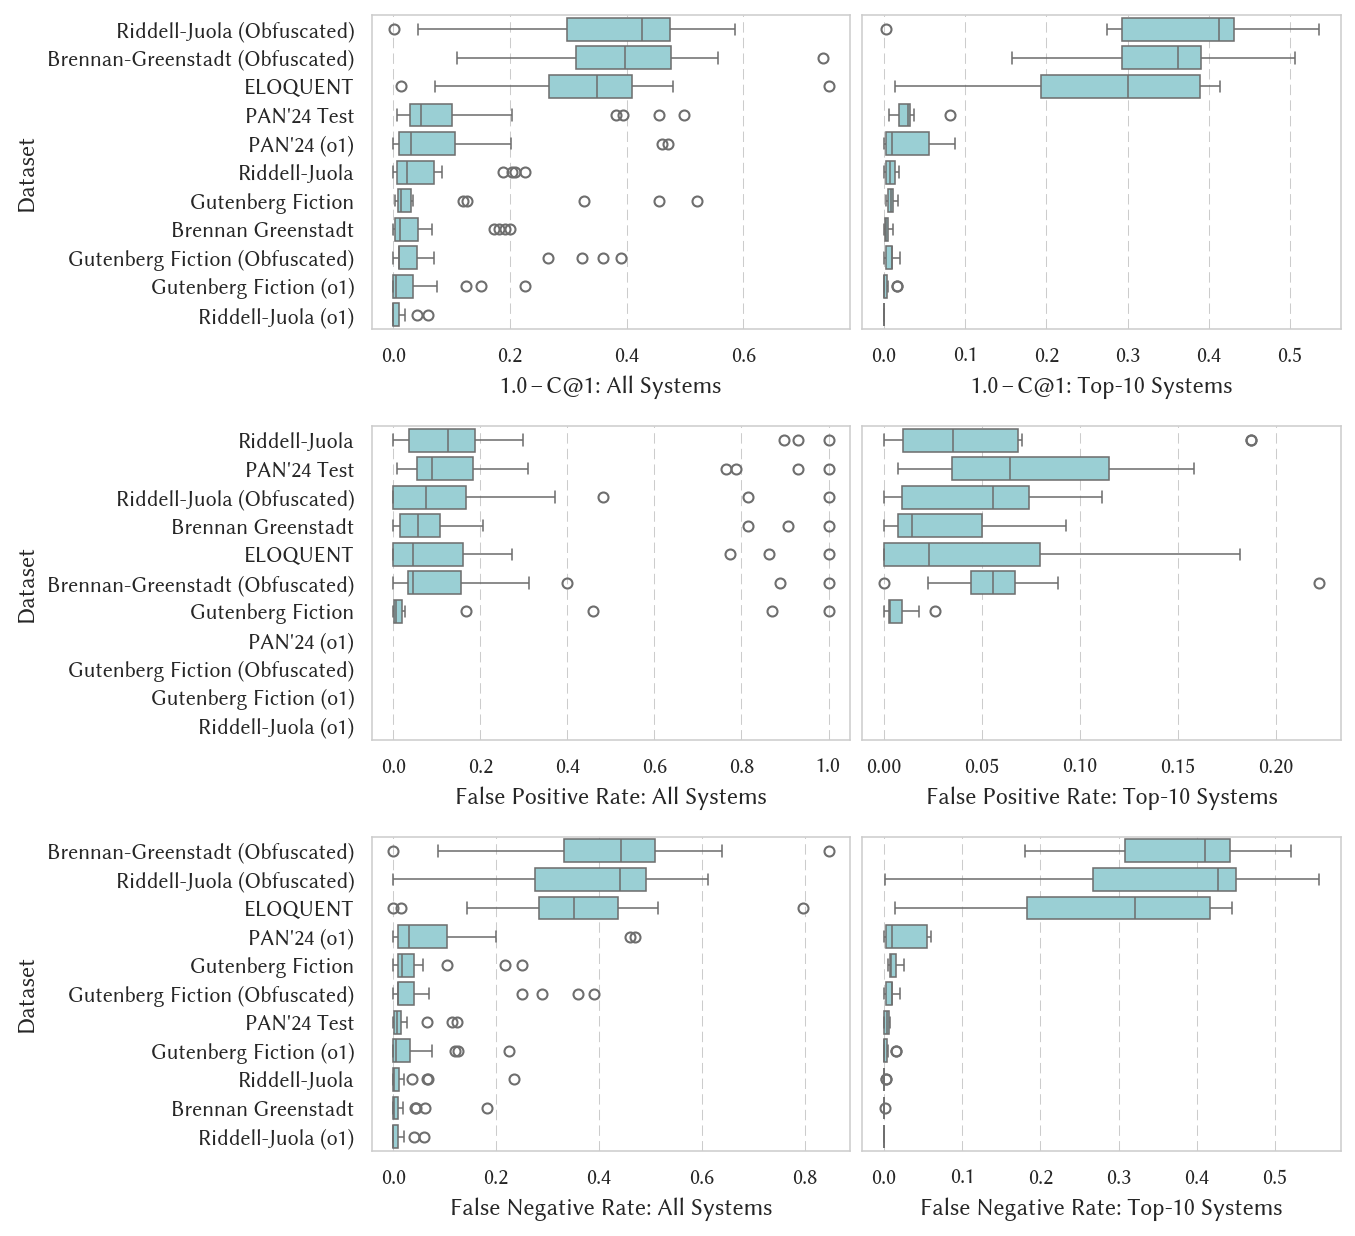

In [25]:
def _plt_dataset_difficulty(ax, df, field, xlabel, order, group_field='eval_value', ylabel='Dataset'):
    sns.boxplot(df, ax=ax, x=field, y=group_field, linewidth=.75, order=order)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

fig, axs = plt.subplots(3, 2, figsize=(9, 8.2), sharey='row')
# fig, axs = plt.subplots(1, 2, figsize=(9, 2.8), sharey='row')

_plt_dataset_difficulty(axs.flat[0],
                        pan_dataset_difficulty_all,
                        'c@1',
                        '1.0 – C@1: All Systems',
                        pan_dataset_difficulty.index)
_plt_dataset_difficulty(axs.flat[1],
                        pan_dataset_difficulty_top10_all,
                        'c@1',
                        '1.0 – C@1: Top-10 Systems',
                        pan_dataset_difficulty.index)

_plt_dataset_difficulty(axs.flat[2],
                        pan_dataset_difficulty_all,
                        'fpr',
                        'False Positive Rate: All Systems',
                        pan_dataset_difficulty.sort_values('fpr', ascending=False).index)
_plt_dataset_difficulty(axs.flat[3],
                        pan_dataset_difficulty_top10_all,
                        'fpr',
                        'False Positive Rate: Top-10 Systems',
                        pan_dataset_difficulty.sort_values('fpr', ascending=False).index)

_plt_dataset_difficulty(axs.flat[4],
                        pan_dataset_difficulty_all,
                        'fnr',
                        'False Negative Rate: All Systems',
                        pan_dataset_difficulty.sort_values('fnr', ascending=False).index)
_plt_dataset_difficulty(axs.flat[5],
                        pan_dataset_difficulty_top10_all,
                        'fnr',
                        'False Negative Rate: Top-10 Systems',
                        pan_dataset_difficulty.sort_values('fnr', ascending=False).index)

# plt.suptitle('Dataset Difficulty', y=.999)
plt.tight_layout(pad=.5, h_pad=1.1)
plt.savefig(OUT_DIR / 'pan_dataset_difficulty.pdf')
plt.show()

In [26]:
obfs_map = {
    'dipper': 'DIPPER',
    '7yo': '7-year-old',
    '7yo-no-kp': '7-year-old (w/o Key Points)',
    'word-order': 'Word Order',
    'temp-1.1': 'High Temperature',
    'alliteration': 'Alliteration',
    'rand-words': 'Random Words'
}

def _map_obfs(o):
    return obfs_map.get(o.split('-obfs-', 1)[1] if '-obfs' in o else o)

obfs_effectiveness = (df_run_eval.query('eval_field in ["model"] and eval_value.str.contains("-obfs-")')
 .reset_index()[['team', 'eval_value', 'fnr']]
 .set_index(['team', 'eval_value']))
obfs_effectiveness['obfs'] = [_map_obfs(x) for x in obfs_effectiveness.reset_index()['eval_value']]
obfs_effectiveness_order = obfs_effectiveness.groupby('obfs').median().sort_values('fnr', ascending=False)
obfs_effectiveness

fnr  \
team   eval_value                                             
Macko  gpt-4.5-preview-obfs-dipper                 0.418605   
       deepseek-r1-distill-qwen-32b-obfs-temp-1.1  0.000000   
       deepseek-r1-distill-qwen-32b-obfs-dipper    0.302326   
       gpt-4o-obfs-7yo                             0.000000   
       gpt-4o-obfs-7yo-no-kp                       0.000000   
...                                                     ...   
Völpel gpt-4.5-preview-obfs-dipper                 0.930233   
       gpt-4o-obfs-alliteration                    0.000000   
       gpt-4o-obfs-rand-words                      0.000000   
       gpt-4o-obfs-word-order                      0.055556   
       gpt-4o-obfs-7yo-no-kp                       0.698630   

                                                                          obfs  
team   eval_value                                                               
Macko  gpt-4.5-preview-obfs-dipper                                      DIPPER  
       deepseek-r1-distill-qwen-32b-obfs-temp-1.1             High Temperature  
       deepseek-r1-distill-qwen-32b-obfs-dipper                         DIPPER  
       gpt-4o-obfs-7yo                                              7-year-old  
       gpt-4o-obfs-7yo-no-kp                       7-year-old (w/o Key Points)  
...                                                                        ...  
Völpel gpt-4.5-preview-obfs-dipper                                      DIPPER  
       gpt-4o-obfs-alliteration                                   Alliteration  
       gpt-4o-obfs-rand-words                                     Random Words  
       gpt-4o-obfs-word-order                                       Word Order  
       gpt-4o-obfs-7yo-no-kp                       7-year-old (w/o Key Points)  

[297 rows x 2 columns]

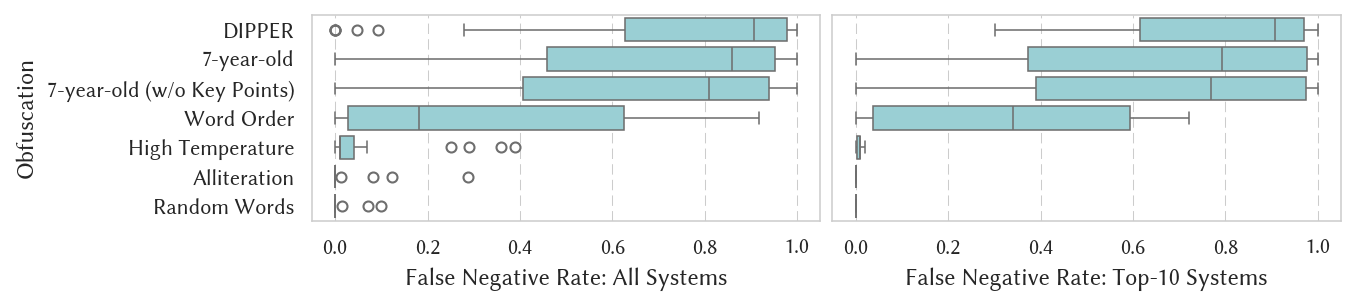

In [27]:
_, axs = plt.subplots(1, 2, figsize=(9, 2), sharey='row')

_plt_dataset_difficulty(axs.flat[0],
                        obfs_effectiveness,
                        'fnr',
                        'False Negative Rate: All Systems',
                        obfs_effectiveness_order.index.values,
                        group_field='obfs',
                        ylabel='Obfuscation')
_plt_dataset_difficulty(axs.flat[1],
                        obfs_effectiveness.query('team in @teams_top10'),
                        'fnr',
                        'False Negative Rate: Top-10 Systems',
                        obfs_effectiveness_order.index.values,
                        group_field='obfs',
                        ylabel='Obfuscation')

plt.tight_layout(pad=.5, h_pad=1.1)
plt.savefig(OUT_DIR / 'pan_dataset_obfs_effectiveness.pdf')
plt.show()

In [28]:
obfs_effectiveness.query('team == "Macko"').groupby('obfs').mean().round(3)

,fnr
obfs,
7-year-old,0.000
7-year-old (w/o Key Points),0.000
Alliteration,0.000
DIPPER,0.419
High Temperature,0.000
Random Words,0.000
Word Order,0.000


### ELOQUENT Evaluation

In [29]:
eloquent_team_map = {
    'adhd': 'adhd',
    'homoglyph': 'Homoglyph',
    'human': 'Human',
    'humanaizers-0': 'HumanAIzers-0',
    'humanaizers-1': 'HumanAIzers-1',
    'humanaizers-2': 'HumanAIzers-2',
    'humanaizers-3': 'HumanAIzers-3',
    'junlp_ss': 'JUNLP_SS',
    'moa': 'Moa',
    'pjs-team-v1': 'PJs-team-v1',
    'pjs-team-v2': 'PJS-team-v2',
    'teamutk': 'TeamUTK',
    'teamutk_bis': 'TeamUTK_bis',
    'translation': 'Translation'
}

df_pred_raw_eloquent = df_pred_raw.query('dataset.str.contains("-eloquent-")').copy()
df_pred_raw_eloquent['eloquent_team'] = df_pred_raw_eloquent.index.get_level_values('id').map(lambda x: eloquent_team_map.get(x.split('/')[1]))
df_pred_raw_eloquent.set_index('eloquent_team', inplace=True, append=True)
df_pred_raw_eloquent.to_csv('../data/tira/eloquent-pred-raw.csv')
df_pred_raw_eloquent.round(3)

label
dataset                                            team                software           run_id              id                         eloquent_team       
pan25-generative-ai-detection-eloquent-20250610... Macko               mdok               2025-06-11-00-34-20 eloquent25/adhd/030        adhd           1.000
                                                   Yang                pink-condenser     2025-06-11-00-40-52 eloquent25/adhd/030        adhd           1.000
                                                   Larson              persistent-strut   2025-06-11-00-34-11 eloquent25/adhd/030        adhd           0.000
                                                   bohan-li            distinct-dachshund 2025-06-11-00-10-49 eloquent25/adhd/030        adhd           1.000
                                                   Liu                 modernbert         2025-06-11-00-34-33 eloquent25/adhd/030        adhd           0.996
...                                                                                                                                                       ...
pan25-generative-ai-detection-eloquent-20250605... Marchitan           tangy-arch         2025-06-05-13-14-07 eloquent25/translation/052 Translation    0.004
                                                   Baseline TF-IDF SVM baseline-tf-idf    2025-06-05-11-20-38 eloquent25/translation/052 Translation    0.374
                                                   Liang               chromatic-fruit    2025-06-05-11-20-25 eloquent25/translation/052 Translation    0.000
                                                   hello-world         tart-objective     2025-06-05-12-11-02 eloquent25/translation/052 Translation    0.374
                                                   Völpel              crabby-announcer   2025-06-05-13-34-59 eloquent25/translation/052 Translation    0.997

[8289 rows x 1 columns]

In [30]:
df_run_eval_eloquent = []
for t in df_pred_raw_eloquent.index.get_level_values('team').unique():
    for ds in df_pred_raw_eloquent.index.get_level_values('eloquent_team').unique():
        p = df_pred_raw_eloquent.query('eloquent_team == @ds and team == @t')
        d = {k: v for k, v in evaluator.evaluate_all(np.array([ds != 'Human'] * len(p)), p['label']).items() if k in ['brier', 'c@1', 'confusion']}
        d['brier'] = 1.0 - d['brier']
        d['c@1'] = 1.0 - d['c@1']
        d['pan_team'] = t
        d['dataset'] = ds
        df_run_eval_eloquent.append(d)
df_run_eval_eloquent = pd.DataFrame(df_run_eval_eloquent).set_index(['dataset', 'pan_team']).sort_values('c@1', ascending=False)
df_run_eval_eloquent['fpr'] = df_run_eval_eloquent['confusion'].map(lambda s: s[0][1] / np.sum(s[0]) if np.sum(s[0]) else 0)
df_run_eval_eloquent['fnr'] = df_run_eval_eloquent['confusion'].map(lambda s: s[1][0] / np.sum(s[1]) if np.sum(s[1]) else 0)

eloquent_leaderboard = df_run_eval_eloquent.groupby('dataset').mean(numeric_only=True).sort_values('c@1', ascending=False)
eloquent_leaderboard.to_latex(OUT_DIR / 'eloquent-leaderboard.tex', float_format=lambda f: f'{f:.3f}')
eloquent_leaderboard.round(3)

,brier,c@1,fpr,fnr
dataset,,,,
PJS-team-v2,0.564,0.626,0.000,0.625
HumanAIzers-0,0.558,0.618,0.000,0.609
Translation,0.558,0.618,0.000,0.609
JUNLP_SS,0.416,0.477,0.000,0.465
HumanAIzers-1,0.391,0.436,0.000,0.428
Homoglyph,0.391,0.436,0.000,0.428
PJs-team-v1,0.244,0.280,0.000,0.276
adhd,0.227,0.241,0.000,0.237
TeamUTK_bis,0.192,0.222,0.000,0.214


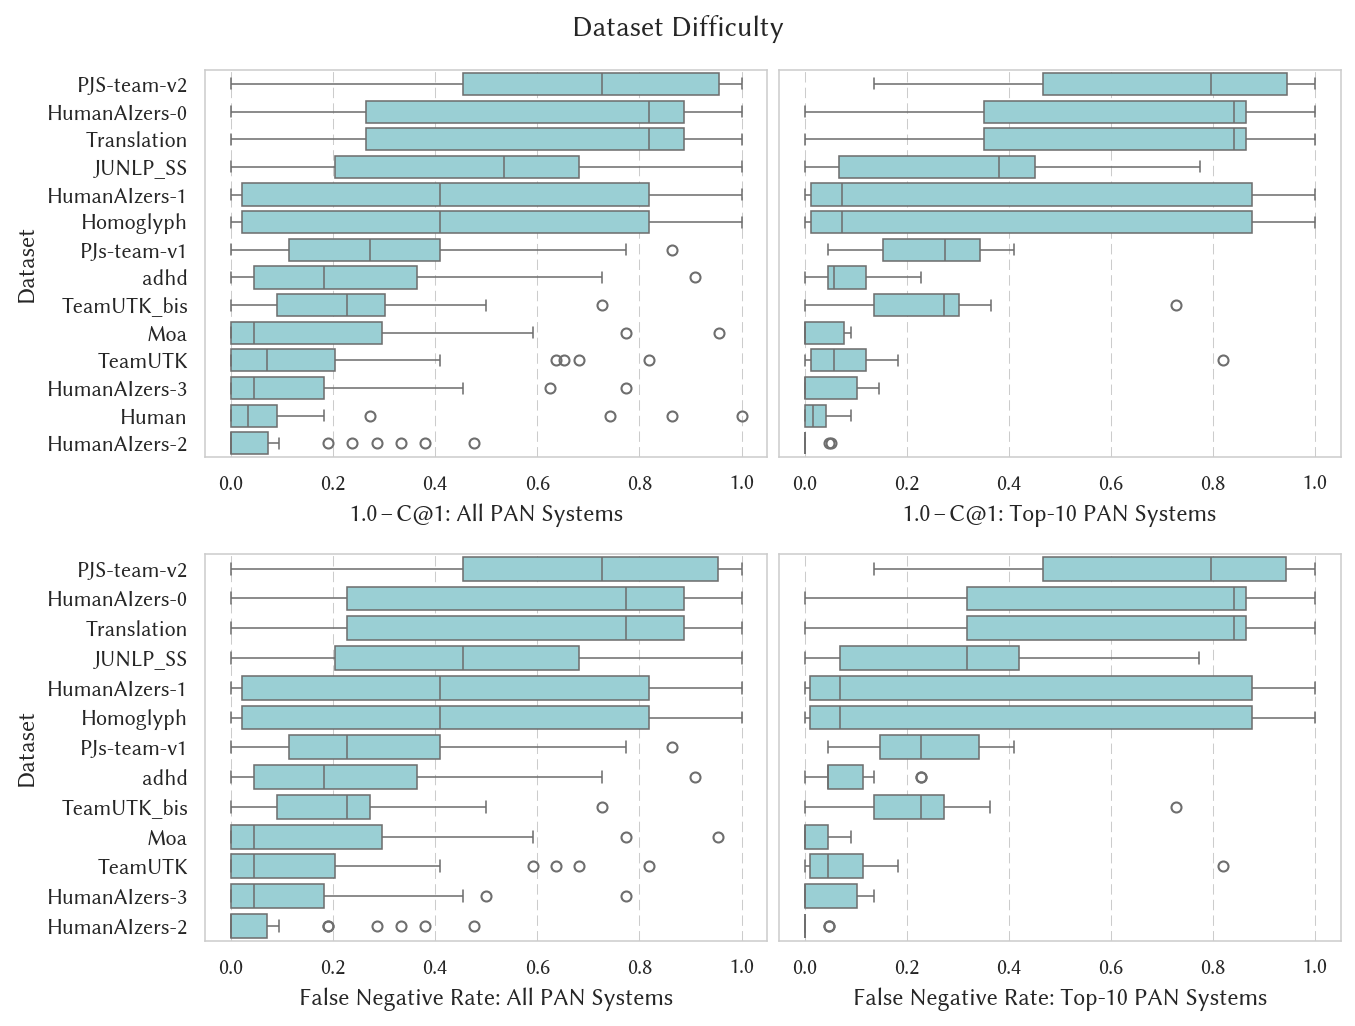

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6.7), sharey='row')

_plt_dataset_difficulty(axs[0][0],
                        df_run_eval_eloquent,
                        'c@1',
                        '1.0 – C@1: All PAN Systems',
                        eloquent_leaderboard.index,
                        group_field='dataset')
_plt_dataset_difficulty(axs[0][1],
                        df_run_eval_eloquent.query('pan_team in @teams_top10'),
                        'c@1',
                        '1.0 – C@1: Top-10 PAN Systems',
                        eloquent_leaderboard.index,
                        group_field='dataset')

_plt_dataset_difficulty(axs[1][0],
                        df_run_eval_eloquent.query('dataset != "Human"'),
                        'fnr',
                        'False Negative Rate: All PAN Systems',
                        [i for i in eloquent_leaderboard.sort_values('fnr', ascending=False).index if i != 'Human'],
                        group_field='dataset')
_plt_dataset_difficulty(axs[1][1],
                        df_run_eval_eloquent.query('dataset != "Human" and pan_team in @teams_top10'),
                        'fnr',
                        'False Negative Rate: Top-10 PAN Systems',
                        [i for i in eloquent_leaderboard.sort_values('fnr', ascending=False).index if i != 'Human'],
                        group_field='dataset')

plt.suptitle('Dataset Difficulty', y=1.003)
plt.tight_layout(pad=.5, h_pad=1.1)
plt.savefig(OUT_DIR / 'eloquent_dataset_difficulty.pdf')
plt.show()

In [32]:
pd.read_json('../data/eloquent25/human.jsonl', lines=True)['text'].map(lambda x: len(x.split())).describe()

count     22.000000
mean     524.590909
std       83.697106
min      354.000000
25%      471.500000
50%      507.500000
75%      564.250000
max      735.000000
Name: text, dtype: float64